# Deep Learning for Diabetic Retinopathy

1. Background
Diabetes affects more than 422 million people in the world, with the majority of those affected residing in low and middle income countries. Diabetes is considered a silent killer i.e. many people live with diabetes without knowing they have the disease. Also with time diabetes results in complications that affect the eye such as diabetic retinopathy, affect the kidneys (diabetic nephropathy)  and affect the nerves (diabetic neuropathy).

Diabetic retinopathy (DR): 
Simply put DR is caused by damage to the blood vessels of the light-sensitive tissue at the back of the eye which is the retina. It is estimated to affet over 90 million people.
Macular edema occurs when there is abnormal leakage and accumulation of fluid in the macula (The macula is part of the retina at the back of the eye. It is only about 5mm across but is responsible for our central vision, most of our colour vision and the fine detail of what we see. The macula has a very high concentration of photoreceptor cells – the cells that detect light) from damaged blood vessels in the nearby retina.

Stages of DR:
Stage 1: Mild nonproliferative diabetic retinopathy
Stage 2: Moderate nonproliferative diabetic retinopathy
Stage 3: Severe nonproliferative diabetic retinopathy
Stage 4: Proliferative diabetic retinopathy.

In early stages there may be no symptoms but as the diabetic retinopathy progresses it can lead to blindness.

The best way to prevent vision loss due to diabetic retinopathy is to have regular screening with an ophthalmologist and start treatment early if required.


2. What should the solution do
As the number of diabetics increases it is important to have a solution that can screen patients with diabetes to determine which patients need to see an ophthalmologist for referral diabetic retinopathy (which is roughly the sum of moderate, severe and proliferative DR) and/ or referable diabetic macular edema as defined by the International Clinical Diabetic Retinopathy Scale. 


3. Example of a Similar solutions with USFDA approval

a. IDx-DR from Digital Diagnostics Inc
Common or Usual Name: Diabetic Retinopathy Detection Device 
Classification Name: Retinal diagnostic software device 
Regulatory Class: II

4. Description of open-source data sets
Kaggle dataset of over 10,000 fundus images 


5. Steps for a simple implementation
    1. We are provided with 10K jpeg fundoscopy images in a folder - "data"
    2. We are also provided a csv with names of 30K images and their levels - 0-4
    3. The first step is to fill in the paths of the 10K files in a new "path" column in the csv
    4. Next we mark those in the rows in the csv for which an image exists and those for which no image exists
    5. Next we set the label - knowing whether an ophthalmologist needs to see the patient or not is more important than predicting the stage. Grade 0 and 1 are set as label 0 as they do not need to see a doctor, rest are given a label 1
    6. Check counts of the 2 classes - to check for class imbalance as that impacts the model and needs to be corrected
    7. Then we do train, validation, test split of the data at 80:10:10. To save time we train on 0.1% of train data (8 of 8000), validate and test on 1% of test and validation set respectively (10 of 1000)
    8. Inspect train, validation and test images with respect to Image dimensions and labels
    9. The images are all different sizes, so they need to be resized to common size (300 * 300) in this case as I am using Densenet pretrained model (the images need to be > 224 * 224)
    10. Prepare the DRD Dataset Class - which is a template used for getting train, validation and test dataset
    11. Prepare train, validation and test loader - which are the tensors used for training, validating and testing the models
    12. Use pretrained Densenet model
    13. Train 2 epochs of forward and backward propagation on the 4 batches each of 2 images
    14. validate on validation set to choose best model
    15. Test on test data to get precision, recall, F1, accuracy 
    16. Finally infer on test data with explaining the prediction - i.e. which parts of the image are being considered for classifying it as mild or severe


In [1]:
# import required modules
import pandas as pd
import numpy as np
import os
import skimage
import itertools
import sys
import matplotlib.pyplot as plt
from skimage.io import imread
import torch
from torchvision import transforms
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data.utils import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.data import ITKReader, PILReader
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism
from monai.visualize import GradCAM
from PIL import Image
import collections
from monai.visualize import CAM
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

In [2]:
base_project_directory = os.path.abspath('') # get the directory of this file
print(base_project_directory) # print the directory of this file

/Users/apple/Documents/Diabetic_Retinopathy


In [3]:
dr_df=pd.read_csv(os.path.join(base_project_directory, 'trainLabels.csv')) # read the csv file
print(dr_df.head()) # print the first 5 rows of the df

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


In [4]:
len(dr_df) # print number of records in the df

35126

In [5]:
print(dr_df['level'].value_counts()) # print the number of each level

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64


In [6]:
dr_df['PatientId'] = dr_df['image'].str.split('_').str[-2] # split the image name by _ and get the patient id
print(dr_df.tail()) # print the last 5 rows of the df

             image  level PatientId
35121  44347_right      0     44347
35122   44348_left      0     44348
35123  44348_right      0     44348
35124   44349_left      0     44349
35125  44349_right      1     44349


In [7]:
# get the path of the images in the data folder and store in "path" column
dr_df['path'] = dr_df['image'].apply(lambda x: os.path.join(base_project_directory, 'data', '{}.jpeg'.format(x))) 

print(dr_df.tail()) # print the last 5 rows of the df

             image  level PatientId  \
35121  44347_right      0     44347   
35122   44348_left      0     44348   
35123  44348_right      0     44348   
35124   44349_left      0     44349   
35125  44349_right      1     44349   

                                                    path  
35121  /Users/apple/Documents/Diabetic_Retinopathy/da...  
35122  /Users/apple/Documents/Diabetic_Retinopathy/da...  
35123  /Users/apple/Documents/Diabetic_Retinopathy/da...  
35124  /Users/apple/Documents/Diabetic_Retinopathy/da...  
35125  /Users/apple/Documents/Diabetic_Retinopathy/da...  


In [8]:
print(dr_df['path'][0]) # print the first path of the images

/Users/apple/Documents/Diabetic_Retinopathy/data/10_left.jpeg


In [9]:
dr_df['exists'] = dr_df['path'].apply(os.path.exists) # check if the image exists and store in "exists" column
print(dr_df.tail()) # print the last 5 rows of the df

             image  level PatientId  \
35121  44347_right      0     44347   
35122   44348_left      0     44348   
35123  44348_right      0     44348   
35124   44349_left      0     44349   
35125  44349_right      1     44349   

                                                    path  exists  
35121  /Users/apple/Documents/Diabetic_Retinopathy/da...   False  
35122  /Users/apple/Documents/Diabetic_Retinopathy/da...   False  
35123  /Users/apple/Documents/Diabetic_Retinopathy/da...   False  
35124  /Users/apple/Documents/Diabetic_Retinopathy/da...   False  
35125  /Users/apple/Documents/Diabetic_Retinopathy/da...    True  


In [10]:
# print the number of images found out of the total number of images
print(dr_df['exists'].sum(), 'images found out of'  , len(dr_df), 'total') 

10024 images found out of 35126 total


In [11]:
# set the label to 0 if the level is less than 2 and 1 if the level is greater than or equal to 2
dr_df['label']=dr_df['level'].apply(lambda x: 0 if x<2 else 1) 

In [12]:
print(dr_df[dr_df['exists']==True].head()) # print the first 5 rows of the df with images that exist

      image  level PatientId  \
0   10_left      0        10   
1  10_right      0        10   
2   13_left      0        13   
3  13_right      0        13   
4   15_left      1        15   

                                                path  exists  label  
0  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
1  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
2  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
3  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
4  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  


In [13]:
print(dr_df[dr_df['exists']==False].head()) # print the first 5 rows of the df with images that do not exist

           image  level PatientId  \
4061  5082_right      0      5082   
4062   5083_left      0      5083   
4063  5083_right      0      5083   
4064   5084_left      0      5084   
4065  5084_right      0      5084   

                                                   path  exists  label  
4061  /Users/apple/Documents/Diabetic_Retinopathy/da...   False      0  
4062  /Users/apple/Documents/Diabetic_Retinopathy/da...   False      0  
4063  /Users/apple/Documents/Diabetic_Retinopathy/da...   False      0  
4064  /Users/apple/Documents/Diabetic_Retinopathy/da...   False      0  
4065  /Users/apple/Documents/Diabetic_Retinopathy/da...   False      0  


In [14]:
drPres_df = dr_df[dr_df['exists']==True] # get the rows of the df with images that exist

In [15]:
drPres_df = drPres_df.reset_index(drop=True) # reset the index of df with images that exist

In [16]:
print(drPres_df.head()) # print the first 5 rows of the df  with images that exist

      image  level PatientId  \
0   10_left      0        10   
1  10_right      0        10   
2   13_left      0        13   
3  13_right      0        13   
4   15_left      1        15   

                                                path  exists  label  
0  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
1  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
2  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
3  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  
4  /Users/apple/Documents/Diabetic_Retinopathy/da...    True      0  


In [17]:
print(len(drPres_df)) # print the number of the df with images that exist

10024


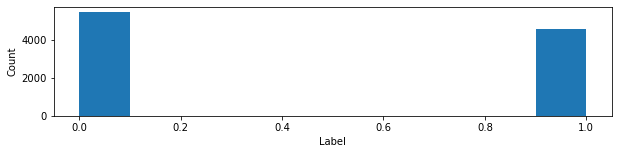

In [18]:
# plot the number of images with each label
plt.figure(figsize=(10,2))
plt.hist(drPres_df['label'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [19]:
print(drPres_df['label'].value_counts()) 

0    5443
1    4581
Name: label, dtype: int64


In [20]:
val_frac = 0.1 # set the validation fraction to 0.1
test_frac = 0.1 # set the test fraction to 0.1
length = len(drPres_df['path']) # get the number of images in the df
indices = np.arange(length) # get the indices of the df
np.random.shuffle(indices) # shuffle the indices

In [21]:
test_split = int(test_frac * length) # get the number of images in the test set
val_split = int(val_frac * length) + test_split # get the number of images in the validation set
test_indices = indices[:test_split] # get the indices of the test set
val_indices = indices[test_split:val_split] # get the indices of the validation set
train_indices = indices[val_split:] # get the indices of the train set

In [22]:
# Use a small subset of the dataset for train, test, validate so that we can run the code quickly
train_indices = train_indices[:int(len(train_indices)*0.001)] # get the first 0.1% of the train indices
val_indices = val_indices[:int(len(val_indices)*0.01)] # get the first 1% of the validation indices
test_indices = test_indices[:int(len(test_indices)*0.01)] # get the first 1% of the test indices

In [23]:
train_x = [drPres_df['path'][i] for i in train_indices] # get the paths of the images in the train set
train_y = [drPres_df['label'][i] for i in train_indices] # get the labels of the images in the train set
val_x = [drPres_df['path'][i] for i in val_indices] # get the paths of the images in the validation set
val_y = [drPres_df['label'][i] for i in val_indices] # get the labels of the images in the validation set
test_x = [drPres_df['path'][i] for i in test_indices] # get the paths of the images in the test set
test_y = [drPres_df['label'][i] for i in test_indices] # get the labels of the images in the test set

In [24]:
# print the number of images in the train, validation, and test set
print(
        f"Training count: {len(train_x)}, Validation count: "
        f"{len(val_x)}, Test count: {len(test_x)}") 


Training count: 8, Validation count: 10, Test count: 10


In [25]:
im= Image.open(train_x[0]) # open the first image in the train set
image_width, image_height = im.size # get the width and height of the image
im.close() # close the image
class_names = set(train_y) # get the set of labels in the train set
num_each=collections.Counter(train_y) # get the number of each label in the train set

In [26]:
# Train set
print('Train set') 
print(f"Total image count: {len(train_x)}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Train set
Total image count: 8
Image dimensions: 3888 x 2592
Label names: {0, 1}
Label counts: Counter({1: 5, 0: 3})


In [27]:
# Validation set
print('Validation set')
im= Image.open(val_x[0]) # open the first image in the validation set
image_width, image_height = im.size # get the width and height of the image
print(f"Total image count: {len(val_x)}") 
print(f"Image dimensions: {image_width} x {image_height}")
class_names = set(val_y) # get the set of labels in the validation set
print(f"Label names: {class_names}")
num_each= collections.Counter(val_y) # get the number of each label in the validation set
print(f"Label counts: {num_each}")

Validation set
Total image count: 10
Image dimensions: 3888 x 2592
Label names: {0, 1}
Label counts: Counter({0: 5, 1: 5})


In [28]:
# Test set
print('Test set')
im= Image.open(test_x[0]) # open the first image in the test set
image_width, image_height = im.size # get the width and height of the image
im.close() # close the image
print(f"Total image count: {len(test_x)}")
print(f"Image dimensions: {image_width} x {image_height}")
class_names = set(test_y) # get the set of labels in the test set
print(f"Label names: {class_names}")
num_each= collections.Counter(test_y) # get the number of each label in the test set
print(f"Label counts: {num_each}")

Test set
Total image count: 10
Image dimensions: 4752 x 3168
Label names: {0, 1}
Label counts: Counter({0: 6, 1: 4})


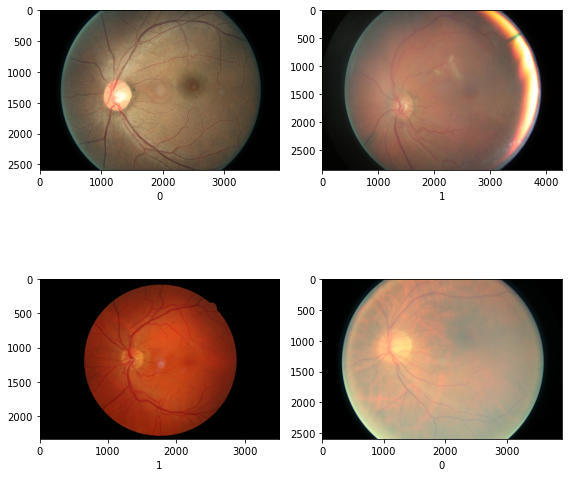

In [29]:
# Plot 4 training images
plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    im = Image.open(train_x[i])
    arr = np.array(im)
    plt.subplot(2, 2, i + 1)
    plt.xlabel(train_y[i])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [30]:
num_class = len(class_names) # get the number of classes

In [31]:
y_pred_trans = Compose([EnsureType(), Activations(softmax=True)]) # Add transformations to y_pred_trans
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)]) # Add transformations to y_trans

In [32]:
# The Diabetic Retinopathy Dataset Class
class DRDataset(torch.utils.data.Dataset): 
    def __init__(self, image_files, labels):
        self.image_files = image_files
        self.labels = labels



    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):

        image_file = self.image_files[index] # get the image file
        label = self.labels[index] # get the label
        image_file = Image.open(image_file) # open the image file
        img = image_file.resize((300,300)) # resize the image
        img=np.array(img) # convert the image to a numpy array
        img=img.transpose((2,0,1)) #get the channels first as required by pytorch (opp in tensorflow)
        img=img/255 # normalize the image
        img=torch.from_numpy(img) # convert the image to a torch tensor
        img=img.float() # convert the image to a float tensor
        label=torch.from_numpy(np.array(label)) # convert the label to a torch tensor
        return (img, label) # return the image and label

In [33]:
train_ds = DRDataset(train_x, train_y) # create the train dataset
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=0) # create the train loader
print(f"length of train data loader: {len(train_loader)}") # print the length of the train loader
print(type(train_loader)) # print the type of the train loader

length of train data loader: 4
<class 'torch.utils.data.dataloader.DataLoader'>


In [34]:
val_ds = DRDataset(val_x, val_y) # create the validation dataset
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=2, num_workers=0) # create the validation loader

In [35]:
test_ds = DRDataset(test_x, test_y) # create the test dataset
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=2, num_workers=0) # create the test loader

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get the device

In [37]:
model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=2).to(device) # create the model
loss_function = torch.nn.CrossEntropyLoss() # create the loss function
optimizer = torch.optim.Adam(model.parameters(), 1e-5) # create the optimizer
max_epochs = 2 # set the maximum number of epochs
val_interval = 1 # set the validation interval
auc_metric = ROCAUCMetric() # create the AUC metric

In [38]:
best_metric = -1 # set the best metric to -1
best_metric_epoch = -1 # set the best metric epoch to -1
epoch_loss_values = [] # create an empty list for the epoch loss values
metric_values = [] # create an empty list for the metric values

In [39]:
for epoch in range(max_epochs):
    print("-" * 10) # print a divider
    print(f"epoch {epoch + 1}/{max_epochs}") # print the epoch
    model.train() # set the model to training mode
    epoch_loss = 0 # set the epoch loss to 0
    step = 0 # set the step to 0
    for batch_data in train_loader: # for each batch in the train loader
        step += 1 # increment the step
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device) # get the inputs and labels
        optimizer.zero_grad() # zero the gradients
        outputs = model(inputs) # get the outputs
        loss = loss_function(outputs, labels) # get the loss
        loss.backward() # backpropagate the loss
        optimizer.step() # update the weights
        epoch_loss += loss.item() # add the loss to the epoch loss
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, " # print the step and the epoch loss
            f"train_loss: {loss.item():.4f}") # print the epoch loss
        epoch_len = len(train_ds) // train_loader.batch_size # get the epoch length
    epoch_loss /= step # get the average epoch loss
    epoch_loss_values.append(epoch_loss) # add the epoch loss to the epoch loss values
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}") # print the epoch average loss
  
    if (epoch + 1) % val_interval == 0: # if the epoch is a validation epoch
        model.eval() # set the model to evaluation mode
        with torch.no_grad(): # do not compute gradients
            # create an empty tensor for the predictions
            y_pred = torch.tensor([], dtype=torch.float32, device=device) 
            
            y = torch.tensor([], dtype=torch.long, device=device) # create an empty tensor for the labels
            for val_data in val_loader: # for each batch in the validation loader
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                ) # get the validation images and labels
                y_pred = torch.cat([y_pred, model(val_images)], dim=0) # get the predictions
                y_pred = torch.softmax(y_pred, dim=1) # get the softmax predictions
                y_pred_sign = y_pred # get the predictions
                y = torch.cat([y, val_labels], dim=0) # get the label

            # De-collate a batch of data. Originally stored as (B,C,H,W,[D]) will be returned as (C,H,W,[D]).
            y_onehot = [y_trans(i) for i in decollate_batch(y)] 
            # De-collate a batch of data. Originally stored as (B,C,H,W,[D]) will be returned as (C,H,W,[D]).
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)] 
            
            auc_metric(y_pred_act, y_onehot) # update the AUC metric
            result = auc_metric.aggregate() # get the AUC metric result
            auc_metric.reset() # reset the AUC metric
            del y_pred_act, y_onehot # delete the predictions and labels
            metric_values.append(result) # add the metric result to the metric values
            acc_value = torch.eq(y_pred.argmax(dim=1), y) # get the accuracy
            acc_metric = acc_value.sum().item() / len(acc_value) # get the accuracy metric
            # print the validation results and the metric at current epoch
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    base_project_directory, "best_metric_model_8.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )


----------
epoch 1/2
1/4, train_loss: 0.6759
2/4, train_loss: 0.7160
3/4, train_loss: 0.7239
4/4, train_loss: 0.6792
epoch 1 average loss: 0.6987
saved new best metric model
current epoch: 1 current AUC: 0.6800 current accuracy: 0.6000 best AUC: 0.6800 at epoch: 1
----------
epoch 2/2
1/4, train_loss: 0.6614
2/4, train_loss: 0.6983
3/4, train_loss: 0.7220
4/4, train_loss: 0.6955
epoch 2 average loss: 0.6943
current epoch: 2 current AUC: 0.6400 current accuracy: 0.5000 best AUC: 0.6800 at epoch: 1


In [40]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}") # print the best metric and the epoch at which it was obtained

train completed, best_metric: 0.6800 at epoch: 1


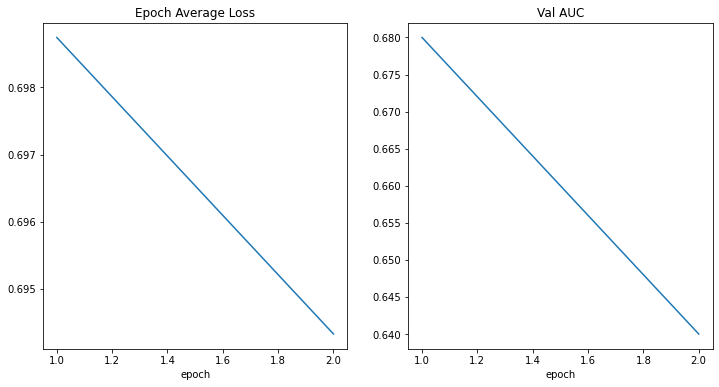

In [41]:
# plot the epoch loss values and Validation AUC values
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [42]:
model.load_state_dict(torch.load(   
os.path.join(base_project_directory, "best_metric_model_8.pth"))) # load the best metric model
model.eval() # set the model to evaluation mode
y_true = [] # create an empty list for the true labels
y_pred = [] # create an empty list for the predicted labels

In [43]:
with torch.no_grad(): # do not compute gradients
    for test_data in test_loader:   # for each batch in the test loader
        test_images, test_labels = (   # get the test images and labels
            test_data[0].to(device), # get the test images
            test_data[1].to(device), # get the test labels
        )
        pred = model(test_images).argmax(dim=1) # get the predictions
        for i in range(len(pred)): # for each prediction
            y_true.append(test_labels[i].item()) # add the true label to the true labels list
            y_pred.append(pred[i].item()) # add the predicted label to the predicted labels list

In [44]:
class_names = set(train_y) # get the class names
class_names=[str(i) for i in class_names] # convert the class names to strings

In [45]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4)) # print the classification report

              precision    recall  f1-score   support

           0     0.6667    1.0000    0.8000         6
           1     1.0000    0.2500    0.4000         4

    accuracy                         0.7000        10
   macro avg     0.8333    0.6250    0.6000        10
weighted avg     0.8000    0.7000    0.6400        10



In [46]:
# get the confusion matrix
cm = confusion_matrix(
    y_true,
    y_pred,
    normalize="true",
) 

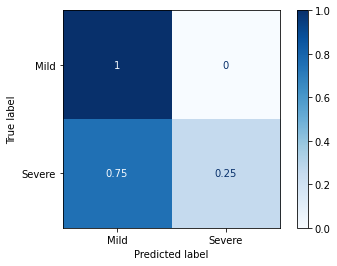

In [47]:
# create a confusion matrix display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Mild", "Severe"],
)
disp.plot(include_values=True, cmap="Blues", ax=None) # plot the confusion matrix
plt.show()

In [48]:
cam = CAM(nn_module=model, target_layers="class_layers.relu", fc_layers="class_layers.out") # create a CAM object

labels tensor(0)
y_pred tensor([0.5073, 0.4927], grad_fn=<SelectBackward0>)
y_pred_abs tensor(0)


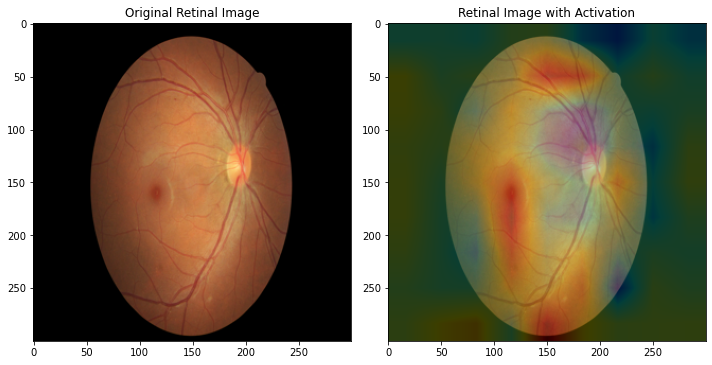

In [49]:
    for batch_data in test_loader: # for each batch in the test loader
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device) # get the inputs and labels
        result = cam(x=inputs) # get the CAM result
        y_pred = model(inputs) # get the predictions
        y_pred=torch.softmax(y_pred,dim=1) # get the softmax predictions
        print('labels',labels[0]) # print the labels
        print('y_pred',y_pred[0]) # print the predictions
        print('y_pred_abs',y_pred[0].argmax(-1)) # print the predictions
        fig, ax = plt.subplots(1,2, figsize=(10,10)) # create a figure and axes
        ima=np.transpose(inputs[0].cpu().detach().numpy(), (1,2,0)) # get the image
        ax[0].imshow(ima) # plot the image
        ax[0].set_title("Original Retinal Image") # set the title
        ax[1].imshow(ima) # plot the image
        ax[1].imshow(skimage.transform.resize(result[0].reshape(300,300), (ima.shape[0],ima.shape[1] )), alpha=0.25, cmap='jet') # plot the heatmap
        y_pred = str(y_pred[0]) # get the predictions
        ax[1].set_title("Retinal Image with Activation") # set the title
        fig.tight_layout() # make the layout tight
        plt.show() # show the figure
        break

Next Steps:
    1. Fine tune the model
    2. Add more transformations to the training data
    3.  Finally and most importantly use all 10,000 images for train, validate, test instead of (8,10,10) to get a better model
